In [18]:
import re
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pypdf
import scipy
import seaborn as sns
import sympy as sp
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

### Scrape web for poem data (get it, clean it, put it in one DataFrame)

Poem links and year of publish:

- [Theme for English B (2002)](https://www.poetryfoundation.org/poems/47880/theme-for-english-b)
- [Harlem (2002)](https://www.poetryfoundation.org/poems/46548/harlem)
- [AmeRícan (1990)](https://www.poetryfoundation.org/poems/58197/american)
- [Lady Liberty (1990)](https://www.poetryfoundation.org/poems/58195/lady-liberty)
- [Autobiography of A Nuyorican (1990)](https://www.sandraesteves.com/images/AutobiographyNuyorican.SandraMariaEsteves.pdf)

In [55]:
def scrape_poems(link: str, class_:str):
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    poem = soup.find_all('div', class_=class_)
    clean_poem = [element.get_text().replace('\xa0', ' ') for element in poem]
    clean_poem = [re.sub(r'\r', '', text) for text in clean_poem if text.strip()]
    tokenize_poem = []
    for item in clean_poem:
        tokenize_poem.extend(sent_tokenize(item))
    
    return pd.DataFrame(tokenize_poem, columns=['Sentence'])

In [57]:
poem1_df = scrape_poems("https://www.poetryfoundation.org/poems/47880/theme-for-english-b", "max-w-full flex-1 md:mb-6")
poem1_df['Title'] = 'Theme for English B'
poem2_df = scrape_poems("https://www.poetryfoundation.org/poems/46548/harlem", "max-w-full flex-1 md:mb-6")
poem2_df['Title'] = 'Harlem'
poem3_df = scrape_poems("https://www.poetryfoundation.org/poems/58197/american", "max-w-full flex-1 md:mb-6")
poem3_df['Title'] = 'AmeRícan'
poem4_df = scrape_poems("https://www.poetryfoundation.org/poems/58195/lady-liberty", "max-w-full flex-1 md:mb-6")
poem4_df['Title'] = 'Lady Liberty'

In [58]:
reader = pypdf.PdfReader('AutobiographyNuyorican.SandraMariaEsteves.pdf')

pdf_text = ""
for num in range(len(reader.pages)):
    pdf_text += reader.pages[num].extract_text()

# Regular expression that matches all text until the period, splits on the period and returns a list of each sentence
# If I used the split('.') method this would have removed periods and I didn't want that
sentences = re.findall(r'[^.]+(?:\.)', pdf_text)
poem5_df = pd.DataFrame(sentences, columns=['Sentence'])
poem5_df['Title'] = 'Autobiography of A Nuyorican'

In [83]:
allpoems = pd.concat([poem1_df, poem2_df, poem3_df, poem4_df, poem5_df], ignore_index=True)
assert len(allpoems) == (len(poem1_df) + len(poem2_df) + len(poem3_df) + len(poem4_df) + len(poem5_df))

In [84]:
allpoems

,Sentence,Title
0,Theme for English BBy Langston HughesShare thi...,Theme for English B
1,"And let that page come out of you— Then,...",Theme for English B
2,I wonder if it’s that simple?,Theme for English B
3,"I am twenty-two, colored, born in Winston-Salem.",Theme for English B
4,"I went to school there, then Durham, then here...",Theme for English B
...,...,...
79,"Gasping and innocent,before she knew her mothe...",Autobiography of A Nuyorican
80,Barely alive.,Autobiography of A Nuyorican
81,Gathering weapons into her beingwith each brea...,Autobiography of A Nuyorican
82,Growing stronger.,Autobiography of A Nuyorican


### Build TF-IDF matrix using `TfidfVectorizer()`

In [85]:
vectorizer = TfidfVectorizer(stop_words='english', norm='l2')
Tfidf = vectorizer.fit_transform(allpoems.Sentence)
Tfidf.shape

(84, 599)

### EDA before choosing k

In [86]:
eda_svd = TruncatedSVD(n_components=599)
eda_lsa = eda_svd.fit_transform(Tfidf)

Text(0, 0.5, 'Singular values of Tfidf')

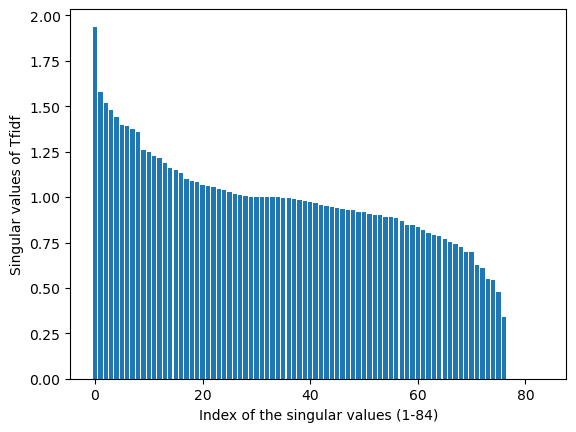

In [87]:
plt.bar([n for n in range(len(eda_svd.singular_values_))], height = eda_svd.singular_values_)
plt.xlabel("Index of the singular values (1-84)") # Some of these, especially after 75 may be non-zero but very small. We know non-zero singular values are one method to figure out the rank of the matrix.
plt.ylabel("Singular values of Tfidf")

Text(0, 0.5, 'Singular values of tf_idf_matrix')

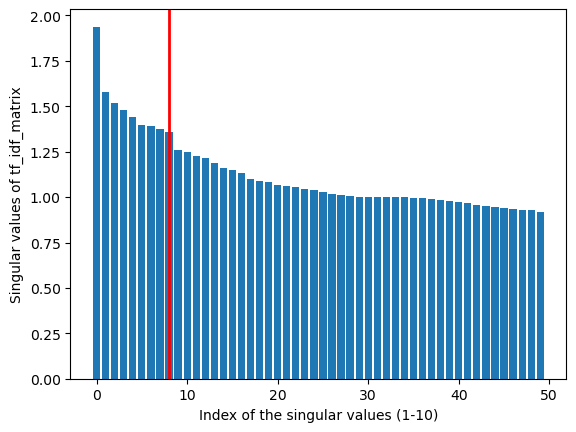

In [88]:
plt.bar([n for n in range(len(eda_svd.singular_values_))[:50]], height = eda_svd.singular_values_[:50])
plt.axvline(x = 8, color = 'r', linestyle = '-', linewidth = 2)
plt.xlabel("Index of the singular values (1-10)")
plt.ylabel("Singular values of tf_idf_matrix")

### Apply SVD, after EDA, using `TruncatedSVD()`

In [89]:
# May need to look at n_components = 8 and specifically at 6, 7, 8
# I think 1-5 will correspond to each poem (similar to previous LSA)

two_svd = TruncatedSVD(n_components=2)
two_lsa = two_svd.fit_transform(Tfidf)

In [91]:
topic_encoded_df = pd.DataFrame(two_lsa, columns=['Topic 1', 'Topic 2'])
topic_encoded_df['Sentence'] = allpoems.Sentence

,Topic 1,Topic 2,Sentence
0,0.216012,-0.214848,Theme for English BBy Langston HughesShare thi...
1,0.045957,-0.093931,"And let that page come out of you— Then,..."
2,0.000082,-0.000301,I wonder if it’s that simple?
3,0.005541,-0.026765,"I am twenty-two, colored, born in Winston-Salem."
4,0.027829,-0.035777,"I went to school there, then Durham, then here..."
...,...,...,...
79,0.001693,0.002280,"Gasping and innocent,before she knew her mothe..."
80,0.000924,0.000768,Barely alive.
81,0.000278,-0.000472,Gathering weapons into her beingwith each brea...
82,-0.000166,0.003477,Growing stronger.


### Explore topics and turn the DataFrames into presentable tables

### Plot topic data

### Explore words in each topic and make this a presentable table